In [1]:
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

Sorting by target in order to get the same result as the book which uses fetch_mldata which is deprecated and the fetch_openml returns an unsorted dataset

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings so here i turn them into 8-bit integers
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

70000 images with 28x28 pixels

In [5]:
X, y = mnist["data"], mnist["target"]

(-0.5, 27.5, 27.5, -0.5)

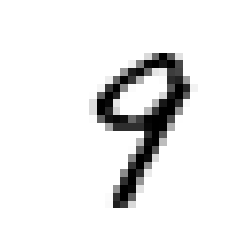

In [6]:
some_digit = X[56300]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary,
          interpolation="nearest")

plt.axis("off")

In [7]:
y[56300]

9

### Reminder: Always create a test set before inspecting the data more closely

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary Classifier

Creation of a binary classifier to identify one single digit. It's used the number 9 here, but it's arbitrary. The model will be able to classify between "5" and "not 5"

In [10]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

### Stochastic Gradient Descent (SGD)

- Capable of handing very large datasets efficiently (deals with training instances independently, one at a time)
- Good for online learning as well

In [28]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
sgd_clf.predict([some_digit])

array([ True])

In [30]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.9443, 0.9496, 0.9427])

Even though this is outputs some good predictions on all folds, it doesn't mean much because only about 10% of the images are 9's. Creating a classifier that guesses if an image is not 9, would result in a 90% accuracy, so cross validation is not the best way to measure the accuracy of a classifier in which some classes are much more frequent than others

### cross_val_predict

- Gives a clean prediction for each instance in the training set divided into k-folds
- The prediction is made by a model that never saw the data during training

In [31]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)

### Confusion Matrix

- Count the number of times instances of class A are classified as class B

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_9, y_train_pred)

array([[53182,   869],
       [ 2489,  3460]], dtype=int64)

First row(negative class, the images that are not 9's) : The model predicted 53182 instances of the non-9's correctly (true negatives) while 869 were predicted incorrectly as being a 9 (false positives). Second row(positive class, the images that are 9's) 3460 were correctly labeled as being a 9 (true positives) while 2489 were wrongly classified as not-9 (false negatives).

### precision_score

- measures the precision of the classifier
- precision = TP / (TP + FP)

where TP is the number of true positives and FP is the number of false positives

### recall_score

- used along with precision_score
- measures the ration of positive instances that are correcly detected by the classifier
- recall = TP / (TP + FN)

where FN is the number of false negatives

In [33]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_9, y_train_pred)

0.7992607992607993

In [34]:
recall_score(y_train_9, y_train_pred)

0.581610354681459

## F1 Score

- Combination of precision and recall into a single metric
- The classifier will only get a high F1 scre if both recall and precision are high as it gives more weight to low values

In [35]:
from sklearn.metrics import f1_score

f1_score(y_train_9, y_train_pred)

0.6732827398326522

### Precision-recall-tradeoff

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3,
                            method="decision_function")

In [38]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

(-700000, 700000)

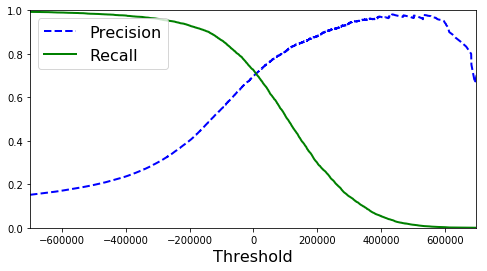

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

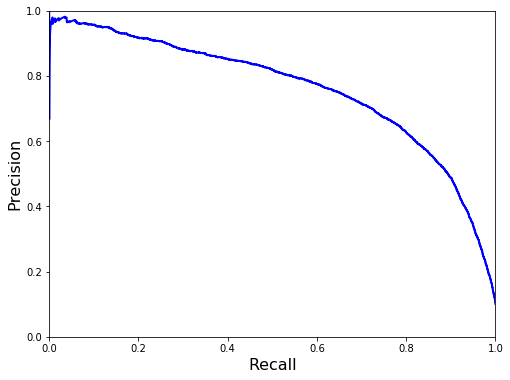

In [40]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [48]:
y_train_pred_90 = (y_scores > 38000)

In [49]:
precision_score(y_train_9, y_train_pred_90)

0.7481653147933565

In [50]:
recall_score(y_train_9, y_train_pred_90)

0.6512018826693562